In [13]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [14]:
data = pd.read_csv("data/dataset.csv")
data.head()

,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
0,1_1_1,-0.805191,-1.141993,-1.328327,-1.516693,-1.373962,-0.80827,-1.070547,-0.504352,2.807146,0.495528,-1.246737
1,1_1_1,-0.805191,-1.134902,-1.320393,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.894177,0.494467,-1.244472
2,1_1_1,-0.805191,-1.117304,-1.307167,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.981904,0.429370,-1.244472
3,1_1_1,-0.814231,-1.114206,-1.287593,-1.442302,-1.287565,-0.80784,-1.045557,-0.516000,3.063298,0.348056,-1.244472
4,1_1_1,-0.848104,-1.112276,-1.285393,-1.429076,-1.270722,-0.80784,-1.017575,-0.664906,3.049237,0.118828,-1.270237


We define anomaly detectors

In [15]:
classifiers = {
    'Elliptic Envelope': EllipticEnvelope(contamination=0.25),
    'Isolation Forest' : IsolationForest(n_estimators=100, contamination=0.15),
    'OCSVM'            : OneClassSVM(nu=0.15, kernel="rbf", gamma=0.3),
}

# Visualization

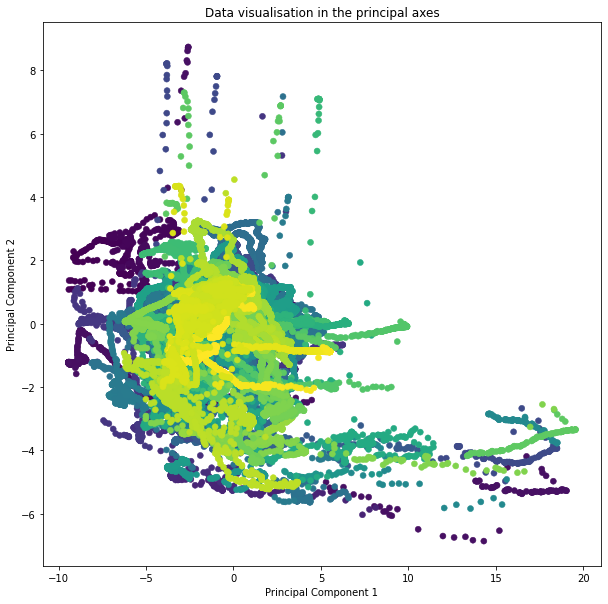

In [16]:
def do_pca(data,nb):
    pca = PCA(n_components=nb)
    results = pca.fit_transform(data)
    return results

def plot_pca(data_pca,title,pred=None) :
    labels = LabelEncoder().fit_transform(data['day_cycle_window'])
    plt.figure(figsize=(10,10))
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    if pred is not None :
        plt.scatter(data_pca[:,0],data_pca[:,1], s=4, lw=0)
        # Plot circles around the predicted outliers
        plt.scatter(data_pca[pred==-1, 0], data_pca[pred==-1, 1], 
           lw=2, facecolors="none", edgecolors="r", s=80, label="predicted outlier")
    else :
        plt.scatter(data_pca[:,0],data_pca[:,1], c=labels, linewidths= 0.5)
    plt.title(title)
    plt.show()

data_pca = do_pca(data.drop('day_cycle_window',axis=1),2)
plot_pca(data_pca,"Data visualisation in the principal axes")

# 1. Naive approach
We know how to classify a point as an anomaly or not. However, a window is a set of 100 points. The first idea is to reduce those 100 points into one point using statiscs. We first calculate the mean of each window.

In [17]:
data_reduced = data.groupby(['day_cycle_window']).mean()

data_reduced.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
day_cycle_window,,,,,,,,,,,
1_1_1,-1.926141,-2.456284,-2.487394,-2.481230,-2.388674,-1.984092,-2.447148,-1.169837,2.848242,-1.370045,-2.500060
1_1_10,1.204735,1.123558,1.077596,1.128253,1.136183,1.228688,1.199106,1.308412,-0.429810,-0.088168,1.016565
1_1_11,0.742475,0.703459,0.680578,0.740626,0.768269,0.736631,0.755362,0.783155,-0.429810,-0.091129,0.669938
1_1_12,0.300162,0.289058,0.289114,0.342999,0.396993,0.254292,0.324268,0.264819,-0.429810,-0.085217,0.303699
1_1_13,0.140935,0.152487,0.161874,0.200016,0.226986,0.083547,0.170042,0.068720,-0.429810,-0.089727,0.186059


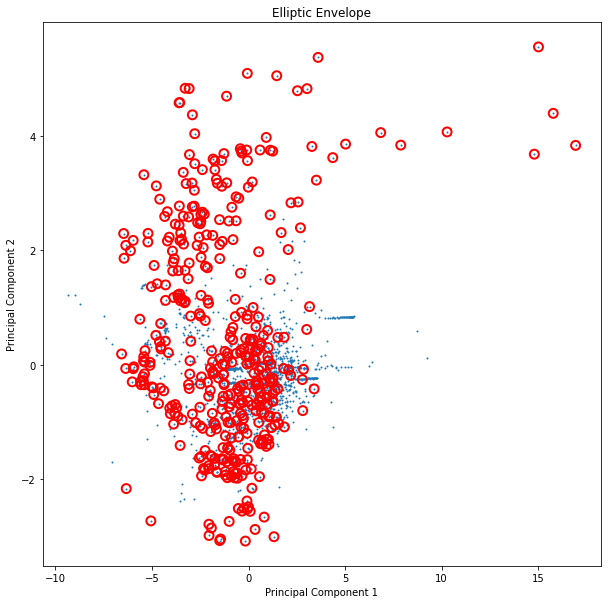

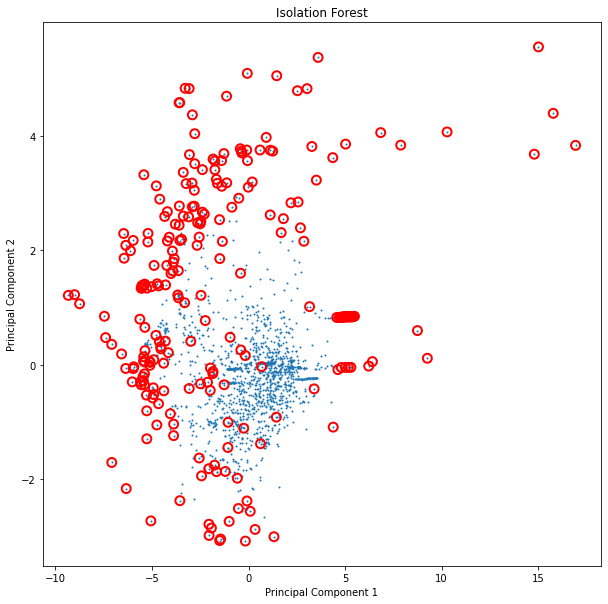

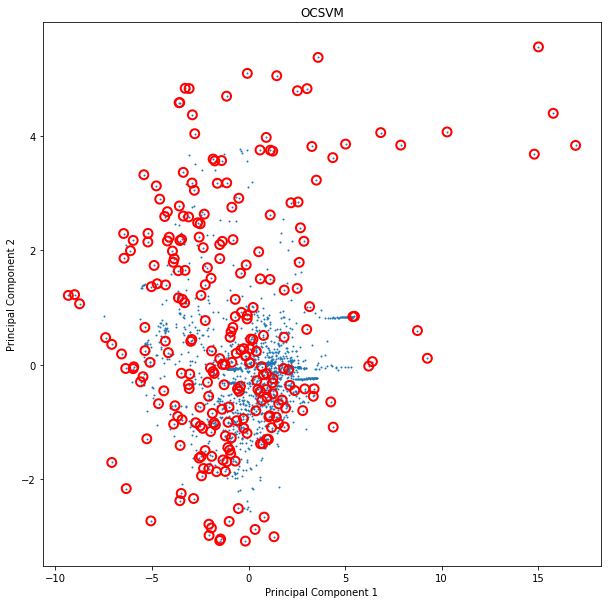

In [18]:
data_reduced_pca = do_pca(data_reduced,2)

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 6, 500), np.linspace(1, 4.5, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(data_reduced)
    pred = clf.predict(data_reduced)
    plot_pca(data_reduced_pca,clf_name,pred=pred)


# 2. A better alternative for the naive approach
Instead of computing the mean, we can extract many other useful characteristics from each window whose points form a sequence or a `time series`. 
We can use the library `tsfresh` to calculate time series features, however we will only use the `mean`, `median`, `maximum`, `minimum`, `standard deviation` and the `number of peaks`. 

In [19]:
from scipy.signal import find_peaks

def num_peaks(seq):
    '''Function that calculates the number of peaks in a series'''
    return len(find_peaks(seq)[0])

In [20]:
data_reduced = data.groupby(['day_cycle_window']).agg(['median','mean','std','max','min',num_peaks])

data_reduced.head()

p1                                                    \
                    median      mean       std       max       min num_peaks   
day_cycle_window                                                               
1_1_1            -1.849016 -1.926141  0.591155 -0.805191 -3.107670         2   
1_1_10            1.118294  1.204735  0.245958  1.582127  0.900633         1   
1_1_11            0.800962  0.742475  0.133627  0.900633  0.486868         0   
1_1_12            0.290764  0.300162  0.089126  0.486868  0.169069         0   
1_1_13            0.137776  0.140935  0.006691  0.161408  0.137776         0   

                        p2                                ...       p10  \
                    median      mean       std       max  ...       std   
day_cycle_window                                          ...             
1_1_1            -2.565392 -2.456284  0.739638 -1.112276  ...  0.673869   
1_1_10            1.037859  1.123558  0.242592  1.528097  ...  0.007340   
1_1_11            0.751052  0.703459  0.132878  0.855591  ...  0.007835   
1_1_12            0.280503  0.289058  0.077160  0.441402  ...  0.008146   
1_1_13            0.150402  0.152487  0.004849  0.167603  ...  0.008337   

                                                     p11                      \
                       max       min num_peaks    median      mean       std   
day_cycle_window                                                               
1_1_1             0.495528 -2.283434        10 -2.857906 -2.500060  0.724468   
1_1_10           -0.070064 -0.107307        19  0.916551  1.016565  0.211292   
1_1_11           -0.075944 -0.106327        11  0.722549  0.669938  0.121043   
1_1_12           -0.068104 -0.101053         9  0.293052  0.303699  0.068842   
1_1_13           -0.070064 -0.103387        10  0.182155  0.186059  0.005184   

                                                
                       max       min num_peaks  
day_cycle_window                                
1_1_1            -1.244472 -3.183571         2  
1_1_10            1.437874  0.807778         1  
1_1_11            0.807778  0.450576         0  
1_1_12            0.450576  0.208743         0  
1_1_13            0.197741  0.179901         2  

[5 rows x 66 columns]

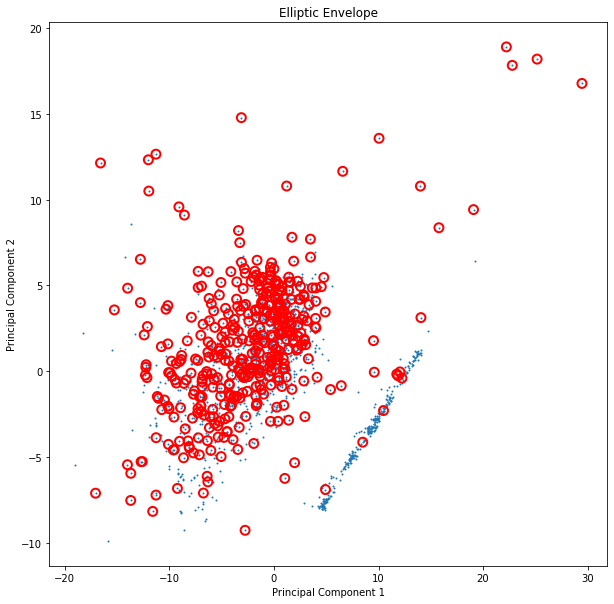

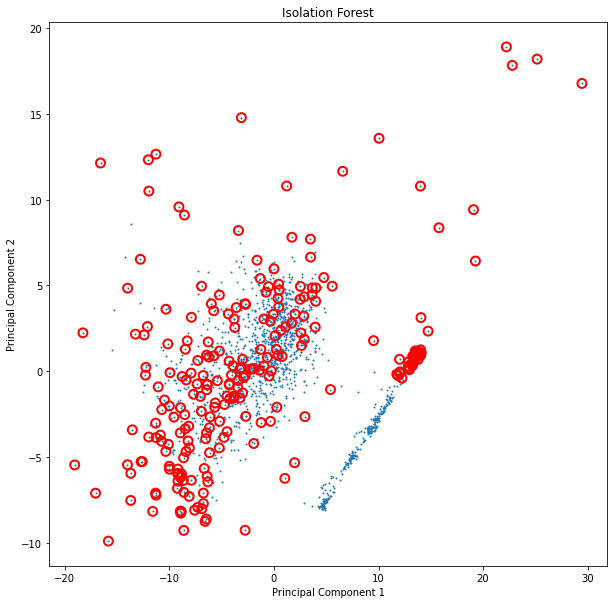

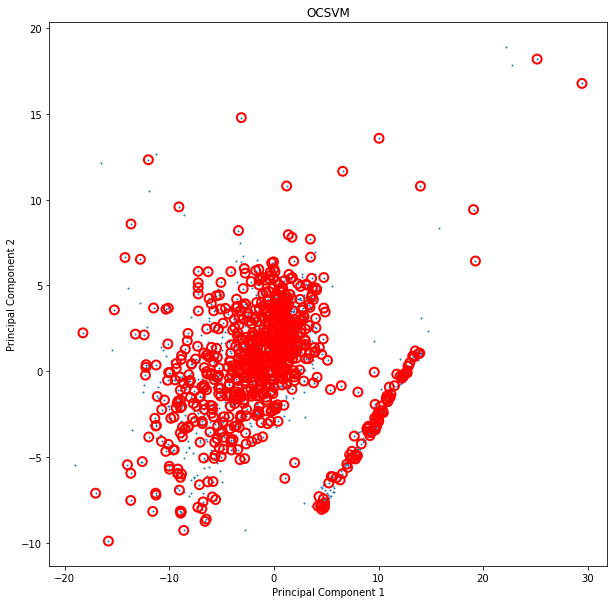

In [26]:
data_reduced_pca = do_pca(data_reduced,2)

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 6, 500), np.linspace(1, 4.5, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(data_reduced)
    pred = clf.predict(data_reduced)
    plot_pca(data_reduced_pca,clf_name,pred=pred)

# 3. A computationally expensive approach

In the hypothesis that the points in each window are sorted by time, we can consider the values of the points as new features. This operation is called a pivot.

In [22]:
data.groupby('day_cycle_window')['p1'].count()[(data.groupby('day_cycle_window')[['p1']].count()!=100).values.flatten()]

day_cycle_window
1_1_68     75
1_2_181     3
1_3_6      53
1_4_17     50
1_5_94     17
2_1_181     2
2_2_76     62
2_3_145    32
3_1_181     3
3_2_52     17
3_3_181     2
4_1_49     85
4_2_181     3
4_3_65     22
4_4_160    76
Name: p1, dtype: int64

There are few window with less than 100 points, those correspond to the end of each cycle. We decide to disregard those windows.

In [23]:
idx_to_remove = data.groupby('day_cycle_window').first().index[(data.groupby('day_cycle_window')[['p1']].count()!=100).values.flatten()]

data_pivoted = data[~data['day_cycle_window'].isin(idx_to_remove)]

In [24]:
data_pivoted['idx'] = data_pivoted.groupby('day_cycle_window').cumcount()+1
data_pivoted = data_pivoted.pivot_table(index='day_cycle_window', columns='idx', 
                    values=data.columns[1:], aggfunc='first')

df = data_pivoted.sort_index(axis=1, level=1)
data_pivoted.columns = [f'{x}_{y}' for x,y in data_pivoted.columns]

data_pivoted.shape
data_pivoted.head()

,p1_1,p1_2,p1_3,p1_4,p1_5,p1_6,p1_7,p1_8,p1_9,p1_10,...,p9_91,p9_92,p9_93,p9_94,p9_95,p9_96,p9_97,p9_98,p9_99,p9_100
day_cycle_window,,,,,,,,,,,,,,,,,,,,,
1_1_1,-0.805191,-0.805191,-0.805191,-0.814231,-0.848104,-0.906958,-1.006352,-1.097180,-1.274279,-1.396218,...,2.676463,2.67288,2.67288,2.67288,2.67288,2.708712,2.711366,2.700455,2.690807,2.690991
1_1_10,1.580110,1.580737,1.580737,1.580737,1.580737,1.580737,1.580737,1.581318,1.582127,1.582127,...,-0.429810,-0.42981,-0.42981,-0.42981,-0.42981,-0.429810,-0.429810,-0.429810,-0.429810,-0.429810
1_1_11,0.900633,0.900633,0.900633,0.900633,0.900633,0.885311,0.883943,0.883943,0.883943,0.883943,...,-0.429810,-0.42981,-0.42981,-0.42981,-0.42981,-0.429810,-0.429810,-0.429810,-0.429810,-0.429810
1_1_12,0.486868,0.476255,0.457712,0.453647,0.453488,0.453488,0.453488,0.453488,0.453488,0.453488,...,-0.429810,-0.42981,-0.42981,-0.42981,-0.42981,-0.429810,-0.429810,-0.429810,-0.429810,-0.429810
1_1_13,0.161408,0.160724,0.160724,0.160724,0.160724,0.160724,0.160724,0.156654,0.150988,0.150988,...,-0.429810,-0.42981,-0.42981,-0.42981,-0.42981,-0.429810,-0.429810,-0.429810,-0.429810,-0.429810


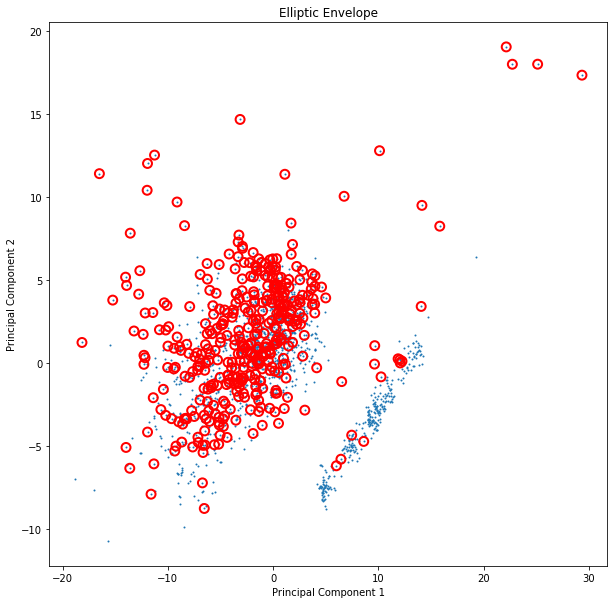

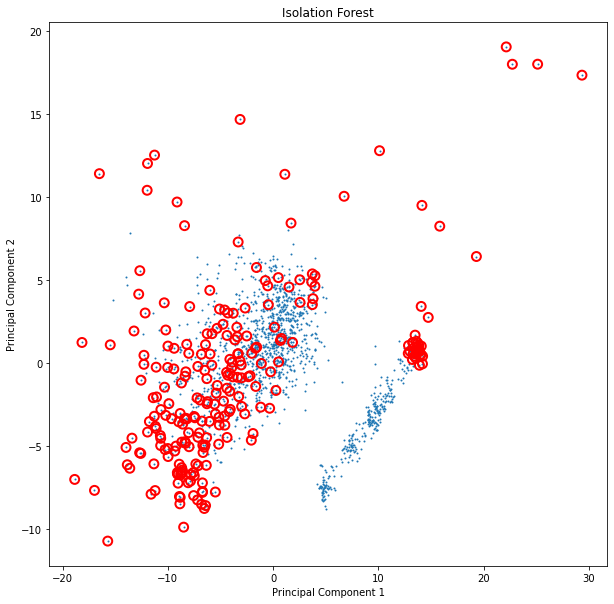

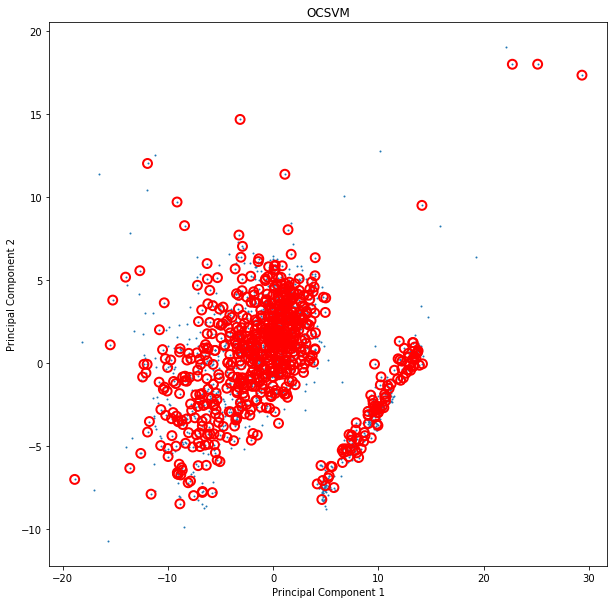

In [27]:
data_reduced_pca = do_pca(data_reduced.drop(idx_to_remove,axis=0),2)

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 6, 500), np.linspace(1, 4.5, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(data_pivoted)
    pred = clf.predict(data_pivoted)
    plot_pca(data_reduced_pca,clf_name,pred=pred)

Like we just saw, 1100 columns is a lot. We can use PCA to reduce that number without losing information unlike the naive method.

<BarContainer object of 10 artists>

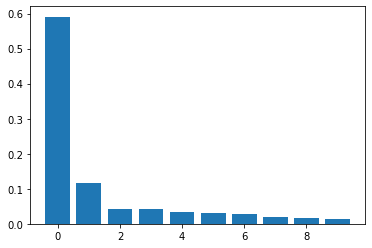

In [28]:
pca = PCA(n_components=10)
pca.fit(data_pivoted)
plt.bar(range(10),pca.explained_variance_ratio_)

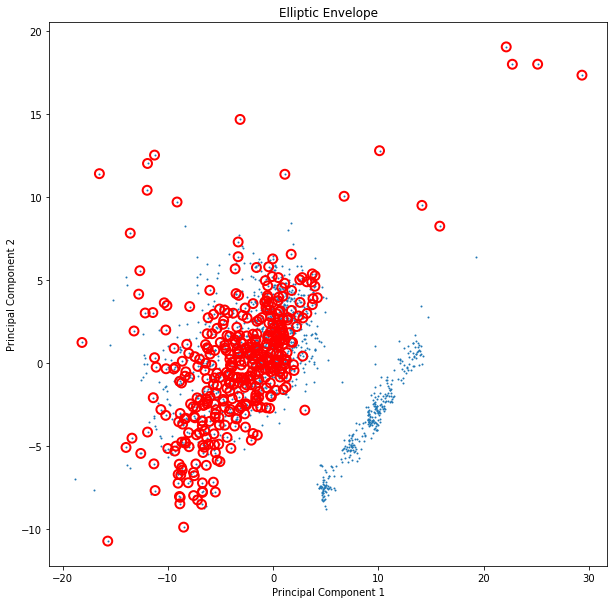

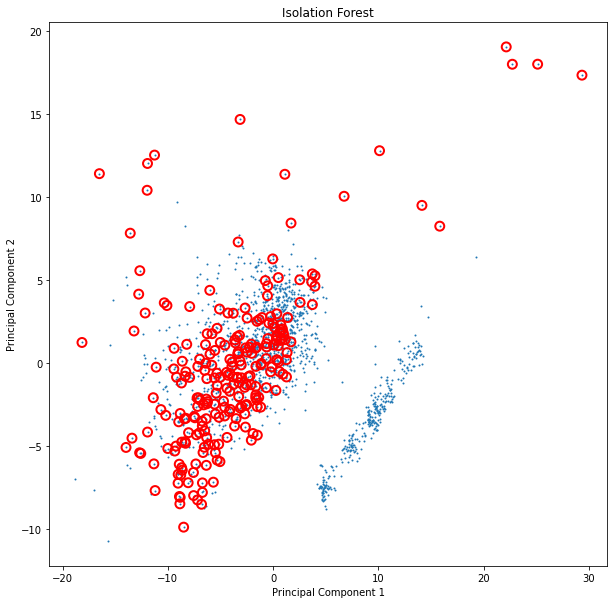

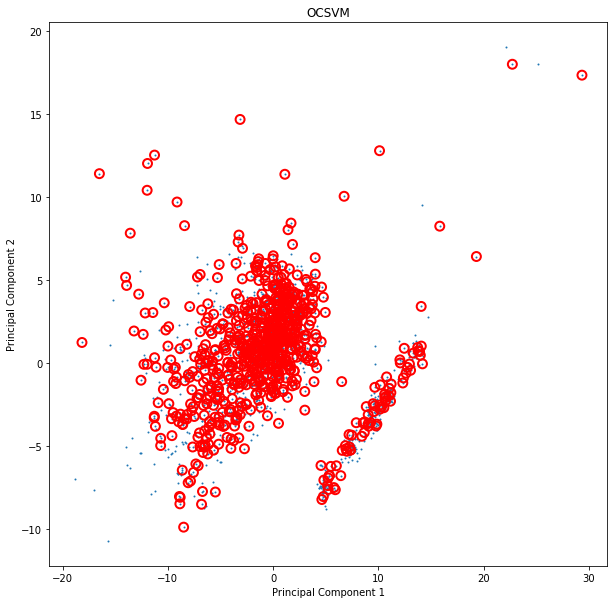

In [29]:
data_pivoted_reduced = do_pca(data_pivoted,10)

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 6, 500), np.linspace(1, 4.5, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(data_pivoted_reduced)
    pred = clf.predict(data_pivoted_reduced)
    plot_pca(data_reduced_pca,clf_name,pred=pred)

Nous remarquons que la différence n'est pas si marquante.